In [1]:
import glob
import h5py
import pandas as pd

from src import io, moco, roi, ttl, zdF
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

In [2]:
# set main data path
base_data_path = "/Volumes/AhmedLab/princess/data"
exp = 1901

# set experiment file path
processed_path = glob.glob(os.path.join(base_data_path, 'processed', f'*{exp}'))[0]
print(processed_path)

/Volumes/AhmedLab/princess/data/processed/251024_1901


In [21]:
# # making functions to load in files
# def load_clusters(experiment_path):
#     file = glob.glob(f'{experiment_path}/*signals.h5')[0]
#     with h5py.File(file, 'r') as f:
#         cluster_labels = f['labels'][...]
#         df = f['df/f'][...]
#     return cluster_labels, df
#
# def load_acquisition_params(experiment_path):
#     file = glob.glob(f'{experiment_path}/*acquisition_parameters.h5')[0]
#     with h5py.File(file, 'r') as f:
#         scope_fr = f['scope_fr'][...]
#         camera_fr = f['camera_fr'][...]
#         brain_dim = f['brain_dimensions'][...]
#         brain_dim= brain_dim.reshape(-1)
#     return scope_fr, camera_fr, brain_dim
#
# def load_fictrac_data(experiment_path):
#     file = glob.glob(f'{experiment_path}/*fictrac.h5')[0]
#     with h5py.File(file, 'r') as f:
#         smoothed_speed = f['smoothed_speed'][...]
#         xy_pos = f['2d_pos'][...]
#         delta_rot = f['delta_rot'][...]
#     return smoothed_speed, xy_pos, delta_rot

# moved to io

In [3]:
# load in data
cluster_labels, signal = io.load_clusters(processed_path)
scope_fr, camera_fr, brain_dim = io.load_acquisition_params(processed_path)
# smoothed_speed, xy_pos, delta_rot = io.load_fictrac_data(processed_path)

In [4]:
# convert maui and behavior time
frames = [x for x in range(1, signal.shape[-1])]
volume_per_s = scope_fr/signal.shape[0] # volume rate in Hz
maui_time = [0] + [x / volume_per_s for x in frames]



In [5]:
# vis features
div_cmap = sns.color_palette('coolwarm', as_cmap=True)
sing_cmap = sns.color_palette('light:b', as_cmap=True)
color = 'b'

In [6]:
print(signal.shape)

(31, 1000, 1339)


In [7]:
signal[13,100].shape

(1339,)

NameError: name 'smoothed_speed' is not defined

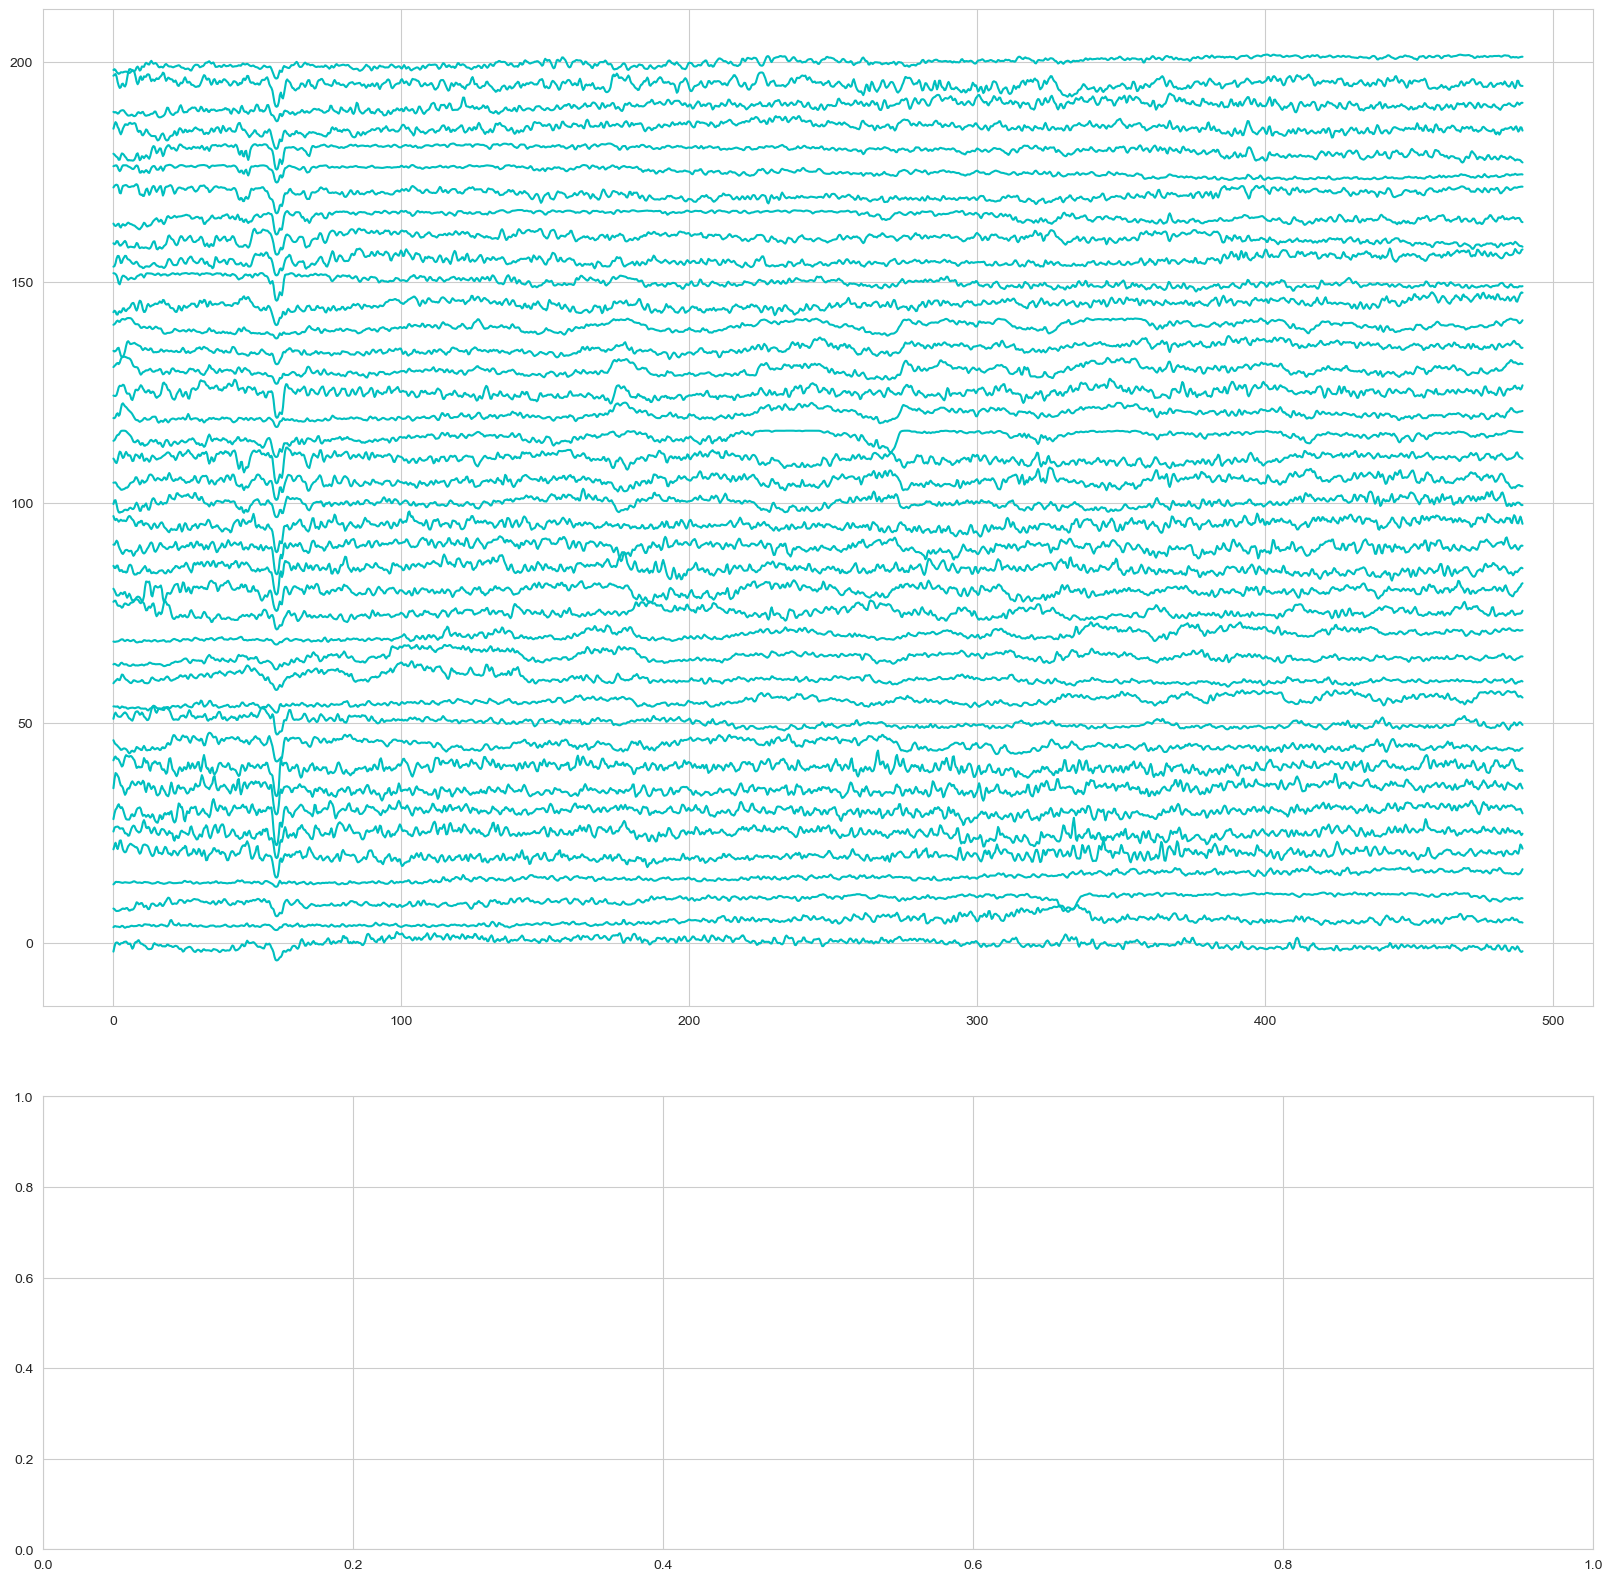

In [8]:
fig0 = plt.figure(figsize=(20,20))
gs = GridSpec(nrows=3, ncols=1, figure=fig0)

y_shift = 5
roi_n = 40

ax0 = fig0.add_subplot(gs[0:2,:])
single_slice = signal[13]
for idx, roi in enumerate(single_slice):
    trace = roi + (y_shift*idx)
    ax0.plot(maui_time, trace, color='c')
    if idx == roi_n:
        break

ax1 = fig0.add_subplot(gs[2, :])
ax1.plot(smoothed_speed, color=color)
plt.ylim(0,6)
plt.xlim(xmin=0, xmax=max(maui_time)+5)
plt.xlabel('time(s)')
plt.ylabel('instantaneous speed (rad/s)')

fig0.tight_layout()
plt.show

(0.0, 1000.0)

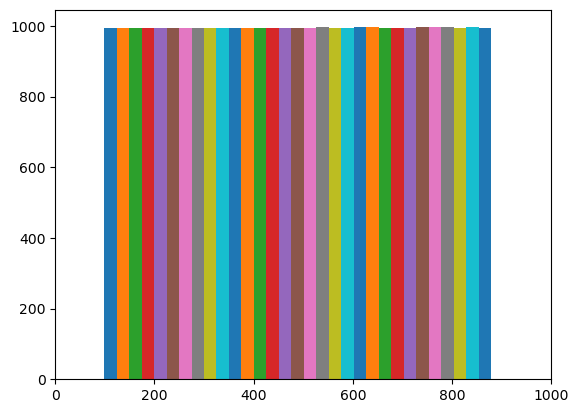

In [75]:
roi_size = []
# how many of each cluster label?
for i, slices in enumerate(cluster_labels):
    values, counts = np.unique(cluster_labels[i], return_counts=True)
    roi_size.append(counts)
plt.hist(roi_size)
plt.xlim(0,1000)

In [80]:
roi_size = np.array(roi_size)
threshold =900
cluster_labels_nobk = []

for slice_idx, clusters in enumerate(cluster_labels):
    # for each slice initialize an array
    # for each v
    for id in cluster_labels[slice_idx]:
        if roi_size[slice_idx, id] > threshold:
            rm_bkg = 0
        else:
            rm_bkg = cluster_labels[slice_idx, id]
        cluster_labels_nobk.append(rm_bkg)
spatial_labels = np.array(cluster_labels_nobk).reshape(signal.shape[0], brain_dim[0], brain_dim[1])
# print(spatial_labels.shape)
spatial_labels.shape

(31, 256, 175)

32


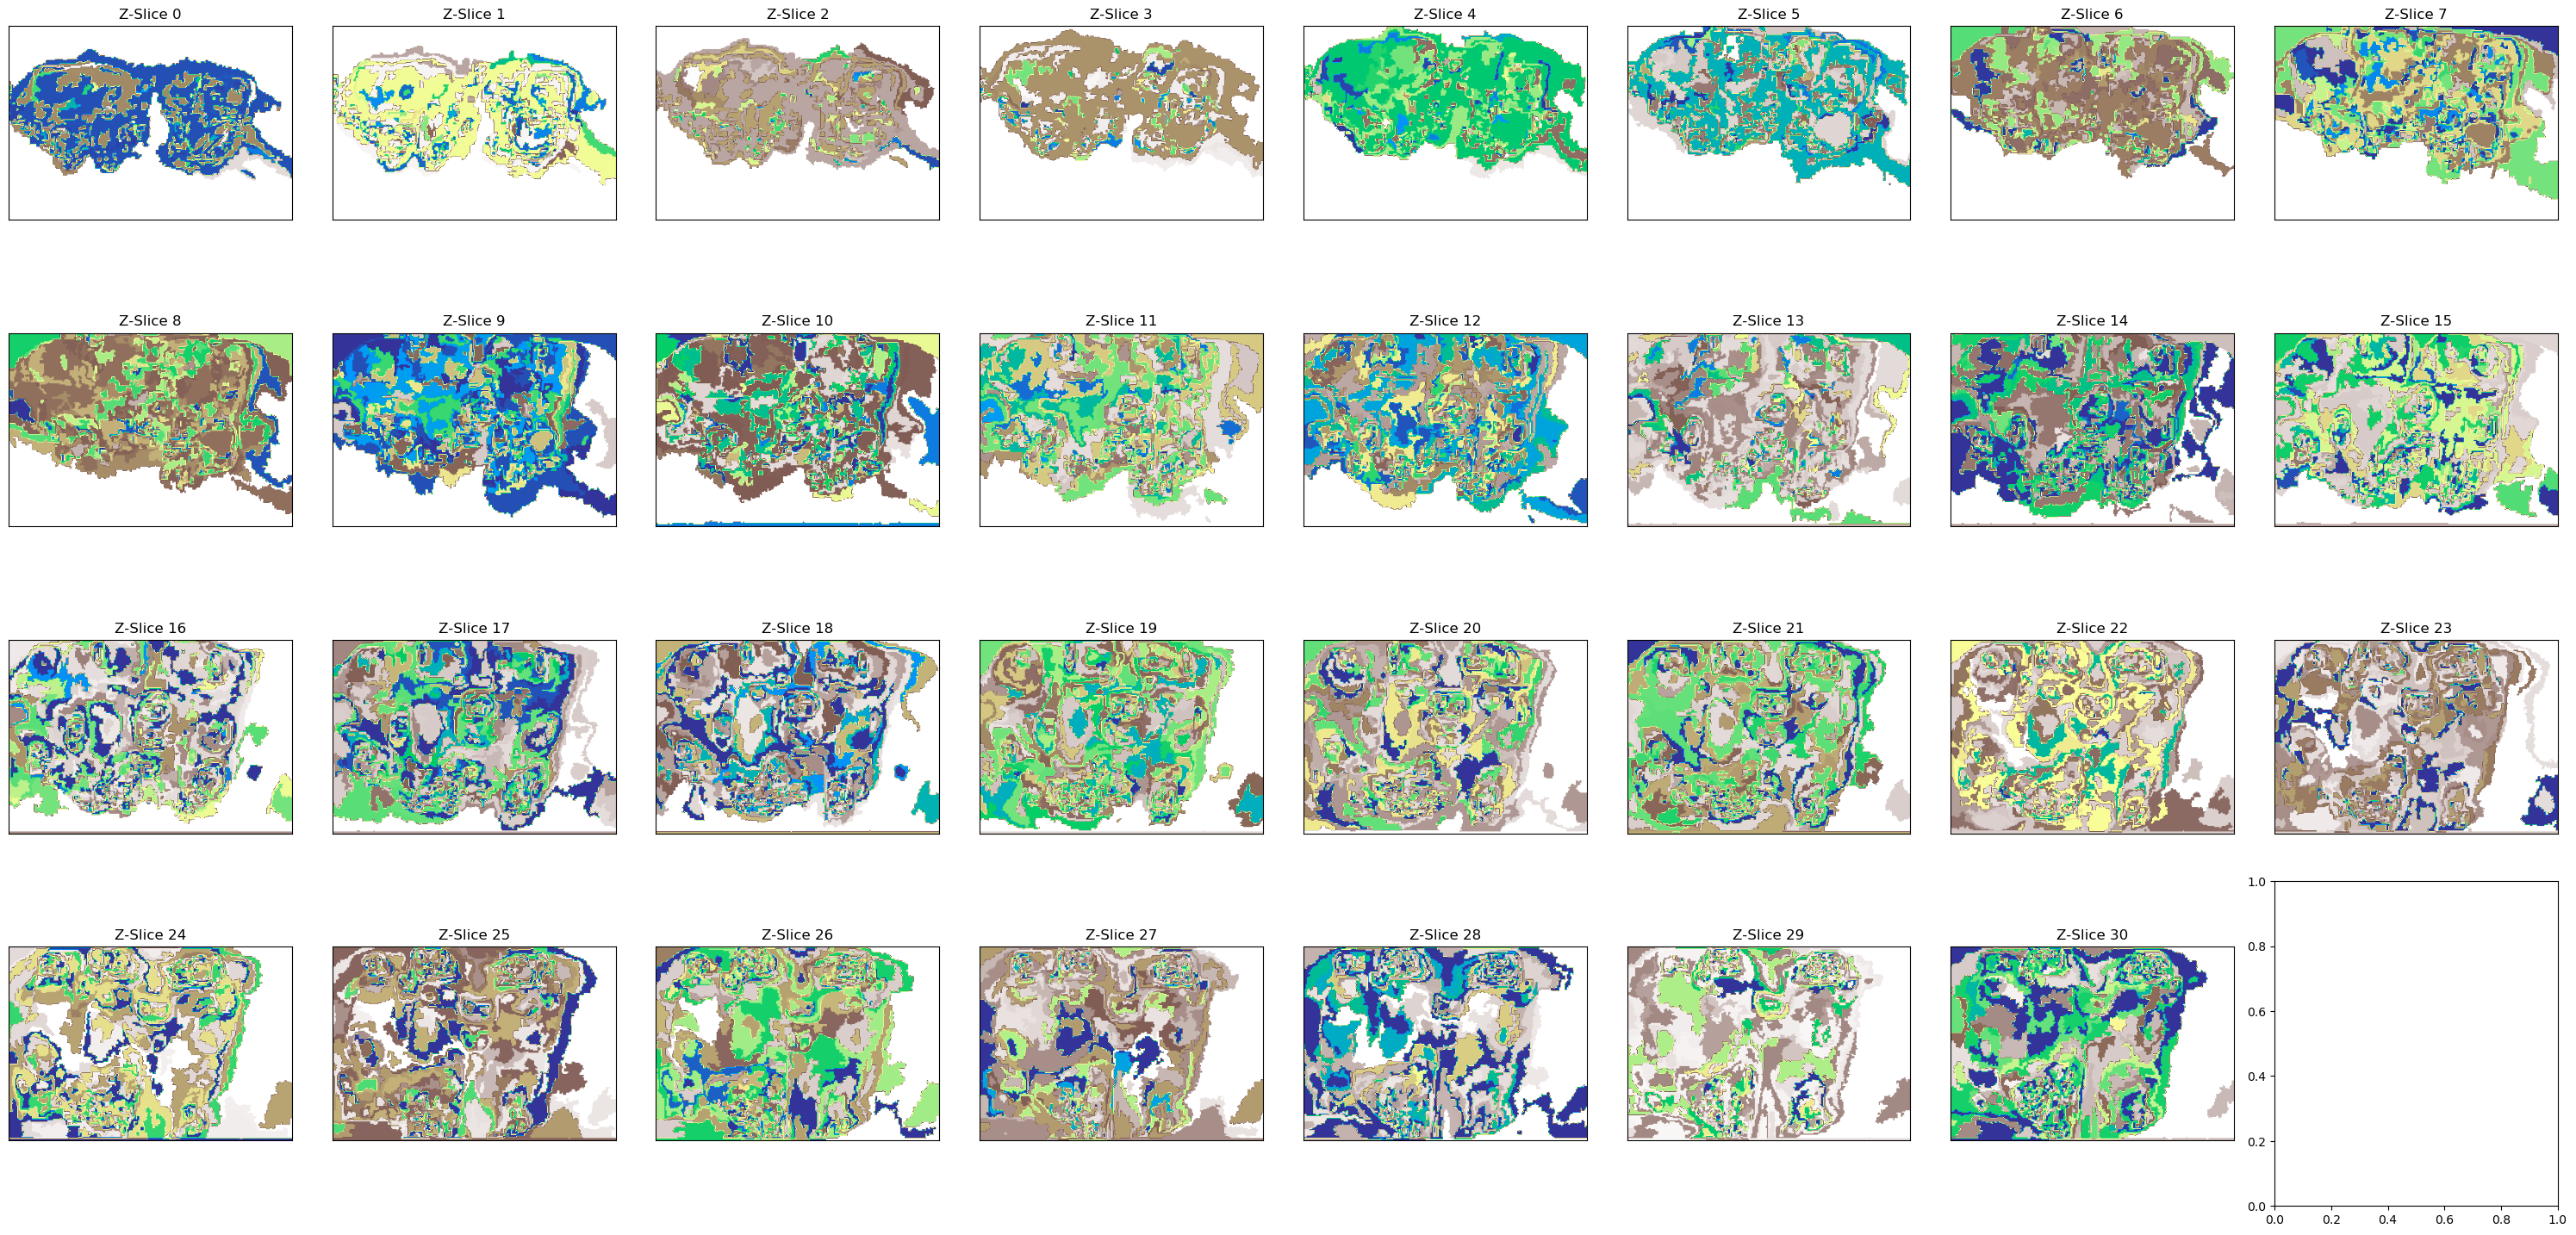

In [81]:
fig, axes = plt.subplots(4, 8, figsize=(30, 15)) # (xaxis, yaxis, figure size)
cmap = 'terrain_r'
# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()
print(len(axes))
images = []
# Populate each subplot with some sample data
for i, ax in enumerate(axes):
    if i < spatial_labels.shape[0]:
        images.append(ax.imshow(spatial_labels[i].T, cmap=cmap))
        ax.set_title(f'Z-Slice {i}')
        ax.set_xticks([]) # Hide x-axis ticks for cleaner appearance
        ax.set_yticks([]) # Hide
# fig.colorbar(images[0], ax=ax, orientation='vertical', fraction=.1)
plt.tight_layout()
plt.show()

In [84]:
fig.savefig(fr'{processed_path}/rawzCa_{exp}_nobackground.svg')

In [ ]:
# plotting z-scored df/F traces of individual ROIs
# plots highest correlated ROIs

fig0 = plt.figure(figsize=(20,20))
gs = GridSpec(nrows=3, ncols=1, figure=fig0)

mean_corr = []
y_shift = 5
roi_n = 40

ax0 = fig0.add_subplot(gs[0:2,:])
for idx, cluster_idx in enumerate(sorted_pearson):
    trace = signal_reshape[cluster_idx, :] + (y_shift*idx)
    ax0.plot(maui_time, trace, color='c')
    mean_corr.append(pearson_arr[cluster_idx])
    if idx == roi_n:
        break
plt.title(fr'average Pearson correlation coefficient = {np.mean(mean_corr):.2f}', loc = 'left')
plt.xlim(xmin=0, xmax=max(maui_time)+5)
plt.ylabel('top 20 correlated rois')

ax1 = fig0.add_subplot(gs[2, :])
ax1.plot(fic_time, fictrac_sp, color=color)
plt.ylim(0,6)
plt.xlim(xmin=0, xmax=max(maui_time)+5)
plt.xlabel('time(s)')
plt.ylabel('instantaneous speed (rad/s)')

fig0.tight_layout()
fig0.savefig(fr'{experiment_path}/rawzCa_{exp_num}.svg')
plt.show